# MAU-Net: MRI Brain Tumour Segmentation

Implementation of Chen et al. (2024) paper - Optimized for RTX 2060 8GB

## Memory Optimizations:
- Input Size: 96×96×96 (reduced from 128×128×128)
- Batch Size: 1
- Mixed Precision: FP16
- Gradient Checkpointing: Enabled

In [1]:
# Install packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install nibabel numpy matplotlib scikit-learn tqdm tensorboard

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')

Device: cuda
GPU: NVIDIA GeForce RTX 2060
Memory: 6.0 GB


## 1. MAU-Net Model

In [3]:
class MDConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        mid = in_channels // 2
        self.conv3 = nn.Conv3d(mid, mid, 3, padding=1, groups=mid)
        self.conv5 = nn.Conv3d(in_channels - mid, in_channels - mid, 5, padding=2, groups=in_channels - mid)
        self.conv1 = nn.Conv3d(in_channels, out_channels, 1)
        
    def forward(self, x):
        mid = x.size(1) // 2
        x1 = self.conv3(x[:, :mid])
        x2 = self.conv5(x[:, mid:])
        return self.conv1(torch.cat([x1, x2], dim=1))

class AGCB(nn.Module):
    """Attention-Guided Context Block"""
    def __init__(self, channels, s=2):
        super().__init__()
        self.s = s
        self.pool = nn.AdaptiveAvgPool3d(s)
        self.q = nn.Conv3d(channels, channels//4, 1)
        self.k = nn.Conv3d(channels, channels//4, 1)
        self.v = nn.Conv3d(channels, channels//4, 1)
        self.out = nn.Conv3d(channels//4, channels, 1)  # Fixed: input channels should be channels//4

    def forward(self, x):
        B, C, D, H, W = x.shape
        g = self.pool(x)
        q, k, v = self.q(g), self.k(g), self.v(g)

        attn = F.softmax(torch.bmm(q.flatten(2).transpose(1, 2), k.flatten(2)), dim=-1)
        feat = torch.bmm(v.flatten(2), attn.transpose(1, 2)).view(B, -1, self.s, self.s, self.s)
        feat = self.out(feat)

        weight = torch.sigmoid(F.interpolate(feat, size=(D, H, W), mode='trilinear'))
        return x + x * weight

class CPM(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.agcb1 = AGCB(channels, s=1)
        self.agcb2 = AGCB(channels, s=2)
        self.conv = nn.Conv3d(channels, channels, 1)

    def forward(self, x):
        a1 = self.agcb1(x)  # Direct call without checkpoint
        a2 = self.agcb2(x)
        return self.conv(a1 + a2)

In [4]:
class SimpleMAUNet(nn.Module):
    def __init__(self, in_channels=4, num_classes=4, dropout_rate=0.2):
        super().__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv3d(in_channels, 32, 3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout_rate)
        )
        self.enc2 = nn.Sequential(
            nn.Conv3d(32, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout_rate)
        )
        self.enc3 = nn.Sequential(
            nn.Conv3d(64, 128, 3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout_rate)
        )
        self.enc4 = nn.Sequential(
            nn.Conv3d(128, 256, 3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout_rate)
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv3d(256, 512, 3, padding=1),
            nn.BatchNorm3d(512),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout_rate * 2)
        )

        # Decoder
        self.dec4 = nn.Sequential(
            nn.Conv3d(512 + 256, 256, 3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout_rate)
        )
        self.dec3 = nn.Sequential(
            nn.Conv3d(256 + 128, 128, 3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout_rate)
        )
        self.dec2 = nn.Sequential(
            nn.Conv3d(128 + 64, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout_rate)
        )
        self.dec1 = nn.Sequential(
            nn.Conv3d(64 + 32, 32, 3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True)
        )

        self.final = nn.Conv3d(32, num_classes, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool3d(e1, 2))
        e3 = self.enc3(F.max_pool3d(e2, 2))
        e4 = self.enc4(F.max_pool3d(e3, 2))

        # Bottleneck
        b = self.bottleneck(F.max_pool3d(e4, 2))

        # Decoder
        d4 = F.interpolate(b, e4.shape[2:], mode='trilinear')
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = F.interpolate(d4, e3.shape[2:], mode='trilinear')
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = F.interpolate(d3, e2.shape[2:], mode='trilinear')
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = F.interpolate(d2, e1.shape[2:], mode='trilinear')
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.final(d1)

# Test the simplified model
model = SimpleMAUNet()
x = torch.randn(1, 4, 96, 96, 96)
model.eval()
with torch.no_grad():
    out = model(x)
    print(f"Input: {x.shape}, Output: {out.shape}")

params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {params:,}")

Input: torch.Size([1, 4, 96, 96, 96]), Output: torch.Size([1, 4, 96, 96, 96])
Parameters: 11,758,404


## 2. Dataset and Loss Functions

In [5]:
class BraTSDataset(Dataset):
    def __init__(self, data_dir, crop_size=(96, 96, 96)):
        self.data_dir = data_dir
        self.crop_size = crop_size

        # Get patient directories
        self.patient_dirs = []
        if os.path.exists(os.path.join(data_dir, 'MICCAI_BraTS2020_TrainingData')):
            train_dir = os.path.join(data_dir, 'MICCAI_BraTS2020_TrainingData')
            self.patient_dirs = [os.path.join(train_dir, d) for d in os.listdir(train_dir)
                               if os.path.isdir(os.path.join(train_dir, d)) and d.startswith('BraTS')]

        print(f"Found {len(self.patient_dirs)} patients")

        # Fixed: Files are .nii not .nii.gz
        self.modalities = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        self.seg_suffix = '_seg.nii'

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        patient_dir = self.patient_dirs[idx]
        patient_id = os.path.basename(patient_dir)

        # Load modalities
        images = []
        for mod in self.modalities:
            path = os.path.join(patient_dir, patient_id + mod)
            if os.path.exists(path):
                img = nib.load(path).get_fdata()
                images.append(img)
            else:
                print(f"Missing: {path}")
                images.append(np.zeros((240, 240, 155)))

        # Load segmentation
        seg_path = os.path.join(patient_dir, patient_id + self.seg_suffix)
        seg = nib.load(seg_path).get_fdata() if os.path.exists(seg_path) else np.zeros_like(images[0])

        # Stack and convert
        image = torch.from_numpy(np.stack(images, axis=0)).float()
        seg = torch.from_numpy(seg).long()

        # Normalize each modality
        for i in range(4):
            img_data = image[i]
            if img_data.max() > 0:
                mean_val = img_data[img_data > 0].mean()
                std_val = img_data[img_data > 0].std()
                if std_val > 0:
                    image[i] = torch.clamp((img_data - mean_val) / std_val, -5, 5)

        # Crop/pad to target size
        image, seg = self._resize(image, seg)

        # Convert labels (4->3)
        seg[seg == 4] = 3

        return image, seg, patient_id

    def _resize(self, image, seg):
        current = image.shape[1:]
        target = self.crop_size

        for i in range(3):
            if current[i] > target[i]:
                start = (current[i] - target[i]) // 2
                end = start + target[i]
                if i == 0:
                    image, seg = image[:, start:end], seg[start:end]
                elif i == 1:
                    image, seg = image[:, :, start:end], seg[:, start:end]
                else:
                    image, seg = image[:, :, :, start:end], seg[:, :, start:end]
            else:
                pad = target[i] - current[i]
                pad_before, pad_after = pad // 2, pad - pad // 2
                if i == 0:
                    image = F.pad(image, (0, 0, 0, 0, pad_before, pad_after))
                    seg = F.pad(seg, (0, 0, 0, 0, pad_before, pad_after))
                elif i == 1:
                    image = F.pad(image, (0, 0, pad_before, pad_after))
                    seg = F.pad(seg, (0, 0, pad_before, pad_after))
                else:
                    image = F.pad(image, (pad_before, pad_after))
                    seg = F.pad(seg, (pad_before, pad_after))

        return image, seg

In [6]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.25):
        super().__init__()
        self.alpha = alpha
        self.ce = nn.CrossEntropyLoss()
    
    def dice_loss(self, pred, target):
        pred = torch.softmax(pred, dim=1)
        dice_scores = []
        for i in range(pred.shape[1]):
            pred_i = pred[:, i].flatten()
            target_i = (target == i).float().flatten()
            intersection = (pred_i * target_i).sum()
            dice = (2 * intersection + 1e-6) / (pred_i.sum() + target_i.sum() + 1e-6)
            dice_scores.append(dice)
        return 1 - torch.stack(dice_scores).mean()
    
    def forward(self, pred, target):
        ce = self.ce(pred, target)
        dice = self.dice_loss(pred, target)
        return (1 - self.alpha) * ce + self.alpha * dice

def dice_coefficient(pred, target):
    pred = torch.argmax(torch.softmax(pred, dim=1), dim=1)
    dice_scores = []
    for i in range(1, 4):  # Skip background
        pred_i = (pred == i).float()
        target_i = (target == i).float()
        intersection = (pred_i * target_i).sum()
        union = pred_i.sum() + target_i.sum()
        dice = (2 * intersection) / union if union > 0 else 1.0
        dice_scores.append(float(dice))  # Convert to float, remove .item()
    return dice_scores

## 3. Training Setup

In [ ]:
# Configuration
config = {
    'data_dir': '/mnt/f/AI700Project/BraTs 2020/BraTS2020_TrainingData',
    'batch_size': 2,
    'learning_rate': 0.001,
    'num_epochs': 50,
    'crop_size': (96, 96, 96)
}

# Create dataset
dataset = BraTSDataset(config['data_dir'], config['crop_size'])
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=1, pin_memory=True)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")

from torch.amp import GradScaler

# Initialize model, loss, optimizer
model = SimpleMAUNet(dropout_rate=0.2).to(device)
criterion = CombinedLoss(alpha=0.25)
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
scaler = GradScaler('cuda')  # Fixed deprecated warning

# Training history
train_losses, val_losses, val_dice_scores = [], [], []

print("✅ Setup complete - ready to train!")

Found 369 patients
Train: 295, Val: 74
✅ Setup complete - ready to train!


## 4. Training Loop

In [8]:
# Add TensorBoard logging
from torch.utils.tensorboard import SummaryWriter
import datetime

# Create TensorBoard writer
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/MAU_Net_{timestamp}')

# Log model architecture (run once)
sample_input = torch.randn(1, 4, 96, 96, 96).to(device)
writer.add_graph(model, sample_input)

print("✅ TensorBoard setup complete!")
print("Run: tensorboard --logdir=runs")

✅ TensorBoard setup complete!
Run: tensorboard --logdir=runs


In [9]:
# Modified training functions with logging
best_val_loss = float('inf')

# Modified training functions with logging
def train_epoch_with_logging(epoch):
    model.train()
    total_loss = 0

    for batch_idx, (images, targets, _) in enumerate(tqdm(train_loader, desc='Training')):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        # Log every 50 batches
        if batch_idx % 50 == 0:
            step = epoch * len(train_loader) + batch_idx
            writer.add_scalar('Loss/Train_Batch', loss.item(), step)

        torch.cuda.empty_cache()

    avg_loss = total_loss / len(train_loader)
    writer.add_scalar('Loss/Train_Epoch', avg_loss, epoch)
    return avg_loss

def validate_with_logging(epoch):
    model.eval()
    total_loss = 0
    all_dice = []

    with torch.no_grad():
        for images, targets, _ in tqdm(val_loader, desc='Validation'):
            images, targets = images.to(device), targets.to(device)

            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, targets)

            total_loss += loss.item()
            dice = dice_coefficient(outputs, targets)
            all_dice.append(dice)

    avg_loss = total_loss / len(val_loader)
    avg_dice = np.mean(all_dice, axis=0)

    # Log validation metrics
    writer.add_scalar('Loss/Validation', avg_loss, epoch)
    writer.add_scalar('Dice/ET', avg_dice[0], epoch)
    writer.add_scalar('Dice/WT', avg_dice[1], epoch)
    writer.add_scalar('Dice/TC', avg_dice[2], epoch)
    writer.add_scalar('Dice/Average', np.mean(avg_dice), epoch)

    # Log learning rate
    writer.add_scalar('Learning_Rate', optimizer.param_groups[0]['lr'], epoch)

    return avg_loss, avg_dice

# Enhanced main training loop
for epoch in range(config['num_epochs']):
    print(f'\nEpoch {epoch+1}/{config["num_epochs"]}')

    # Train and validate with logging
    train_loss = train_epoch_with_logging(epoch)
    val_loss, val_dice = validate_with_logging(epoch)

    # Update history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_dice_scores.append(val_dice)

    scheduler.step(val_loss)

    print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    print(f'Dice - ET: {val_dice[0]:.3f}, WT: {val_dice[1]:.3f}, TC: {val_dice[2]:.3f}')

    # Log sample predictions every 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            sample_images, sample_targets, _ = next(iter(val_loader))
            sample_images = sample_images.to(device)
            sample_outputs = model(sample_images)
            sample_pred = torch.argmax(torch.softmax(sample_outputs, dim=1), dim=1)

            # Log images (middle slice)
            mid_slice = sample_images.shape[4] // 2
            writer.add_image(f'Input/FLAIR_Epoch_{epoch+1}',
                           sample_images[0, 0, :, :, mid_slice], epoch, dataformats='HW')
            writer.add_image(f'Target/Ground_Truth_Epoch_{epoch+1}',
                           sample_targets[0, :, :, mid_slice], epoch, dataformats='HW')
            writer.add_image(f'Prediction/Model_Output_Epoch_{epoch+1}',
                           sample_pred[0, :, :, mid_slice], epoch, dataformats='HW')

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_mau_net.pth')
        print('✓ Best model saved!')

# Close writer
writer.close()
print("\n✅ Training complete! Check TensorBoard: tensorboard --logdir=runs")


Epoch 1/50


Validation: 100%|██████████| 37/37 [02:42<00:00,  4.39s/it]


Train Loss: 0.5431, Val Loss: 0.2778
Dice - ET: 0.042, WT: 0.712, TC: 0.760
✓ Best model saved!

Epoch 2/50


Validation: 100%|██████████| 37/37 [02:50<00:00,  4.61s/it]


Train Loss: 0.2345, Val Loss: 0.1890
Dice - ET: 0.280, WT: 0.710, TC: 0.768
✓ Best model saved!

Epoch 3/50


Validation: 100%|██████████| 37/37 [03:03<00:00,  4.97s/it]


Train Loss: 0.1964, Val Loss: 0.1889
Dice - ET: 0.430, WT: 0.659, TC: 0.743
✓ Best model saved!

Epoch 4/50


Validation: 100%|██████████| 37/37 [01:42<00:00,  2.78s/it]


Train Loss: 0.1800, Val Loss: 0.1551
Dice - ET: 0.466, WT: 0.728, TC: 0.808
✓ Best model saved!

Epoch 5/50


Validation: 100%|██████████| 37/37 [03:06<00:00,  5.03s/it]


Train Loss: 0.1810, Val Loss: 0.1530
Dice - ET: 0.485, WT: 0.735, TC: 0.790
✓ Best model saved!

Epoch 6/50


Validation: 100%|██████████| 37/37 [03:04<00:00,  5.00s/it]


Train Loss: 0.1666, Val Loss: 0.1449
Dice - ET: 0.470, WT: 0.739, TC: 0.803
✓ Best model saved!

Epoch 7/50


Validation: 100%|██████████| 37/37 [03:02<00:00,  4.92s/it]


Train Loss: 0.1663, Val Loss: 0.1706
Dice - ET: 0.450, WT: 0.687, TC: 0.752

Epoch 8/50


Validation: 100%|██████████| 37/37 [01:31<00:00,  2.48s/it]


Train Loss: 0.1634, Val Loss: 0.1631
Dice - ET: 0.472, WT: 0.711, TC: 0.789

Epoch 9/50


Validation: 100%|██████████| 37/37 [01:46<00:00,  2.87s/it]


Train Loss: 0.1626, Val Loss: 0.1371
Dice - ET: 0.492, WT: 0.752, TC: 0.808
✓ Best model saved!

Epoch 10/50


Validation: 100%|██████████| 37/37 [02:55<00:00,  4.73s/it]

Train Loss: 0.1611, Val Loss: 0.1523
Dice - ET: 0.473, WT: 0.685, TC: 0.796



Epoch 11/50


Validation: 100%|██████████| 37/37 [03:08<00:00,  5.09s/it]


Train Loss: 0.1580, Val Loss: 0.1439
Dice - ET: 0.486, WT: 0.719, TC: 0.816

Epoch 12/50


Validation: 100%|██████████| 37/37 [03:10<00:00,  5.15s/it]


Train Loss: 0.1576, Val Loss: 0.1571
Dice - ET: 0.476, WT: 0.724, TC: 0.765

Epoch 13/50


Validation: 100%|██████████| 37/37 [01:30<00:00,  2.45s/it]


Train Loss: 0.1529, Val Loss: 0.1410
Dice - ET: 0.433, WT: 0.758, TC: 0.814

Epoch 14/50


Validation: 100%|██████████| 37/37 [03:05<00:00,  5.02s/it]


Train Loss: 0.1519, Val Loss: 0.1298
Dice - ET: 0.499, WT: 0.765, TC: 0.821
✓ Best model saved!

Epoch 15/50


Validation: 100%|██████████| 37/37 [03:04<00:00,  4.99s/it]


Train Loss: 0.1587, Val Loss: 0.1498
Dice - ET: 0.437, WT: 0.714, TC: 0.796

Epoch 16/50


Validation: 100%|██████████| 37/37 [03:04<00:00,  4.99s/it]


Train Loss: 0.1565, Val Loss: 0.1375
Dice - ET: 0.504, WT: 0.741, TC: 0.820

Epoch 17/50


Validation: 100%|██████████| 37/37 [02:43<00:00,  4.41s/it]


Train Loss: 0.1530, Val Loss: 0.1303
Dice - ET: 0.516, WT: 0.765, TC: 0.816

Epoch 18/50


Validation: 100%|██████████| 37/37 [03:01<00:00,  4.90s/it]


Train Loss: 0.1492, Val Loss: 0.1550
Dice - ET: 0.498, WT: 0.719, TC: 0.744

Epoch 19/50


Validation: 100%|██████████| 37/37 [03:03<00:00,  4.96s/it]


Train Loss: 0.1580, Val Loss: 0.1340
Dice - ET: 0.515, WT: 0.740, TC: 0.816

Epoch 20/50


Validation: 100%|██████████| 37/37 [02:53<00:00,  4.68s/it]

Train Loss: 0.1493, Val Loss: 0.1343
Dice - ET: 0.539, WT: 0.729, TC: 0.817



Epoch 21/50


Validation: 100%|██████████| 37/37 [03:02<00:00,  4.93s/it]


Train Loss: 0.1496, Val Loss: 0.1357
Dice - ET: 0.493, WT: 0.733, TC: 0.820

Epoch 22/50


Validation: 100%|██████████| 37/37 [03:02<00:00,  4.92s/it]


Train Loss: 0.1515, Val Loss: 0.1311
Dice - ET: 0.531, WT: 0.768, TC: 0.810

Epoch 23/50


Validation: 100%|██████████| 37/37 [02:59<00:00,  4.84s/it]


Train Loss: 0.1524, Val Loss: 0.1408
Dice - ET: 0.508, WT: 0.737, TC: 0.793

Epoch 24/50


Validation: 100%|██████████| 37/37 [03:01<00:00,  4.91s/it]


Train Loss: 0.1470, Val Loss: 0.1323
Dice - ET: 0.537, WT: 0.741, TC: 0.797

Epoch 25/50


Validation: 100%|██████████| 37/37 [03:05<00:00,  5.00s/it]


Train Loss: 0.1506, Val Loss: 0.1399
Dice - ET: 0.394, WT: 0.773, TC: 0.812

Epoch 26/50


Validation: 100%|██████████| 37/37 [02:57<00:00,  4.79s/it]


Train Loss: 0.1460, Val Loss: 0.1222
Dice - ET: 0.516, WT: 0.787, TC: 0.824
✓ Best model saved!

Epoch 27/50


Validation: 100%|██████████| 37/37 [03:10<00:00,  5.14s/it]


Train Loss: 0.1398, Val Loss: 0.1219
Dice - ET: 0.550, WT: 0.775, TC: 0.822
✓ Best model saved!

Epoch 28/50


Validation: 100%|██████████| 37/37 [04:33<00:00,  7.38s/it]


Train Loss: 0.1404, Val Loss: 0.1363
Dice - ET: 0.512, WT: 0.750, TC: 0.823

Epoch 29/50


Validation: 100%|██████████| 37/37 [03:03<00:00,  4.96s/it]


Train Loss: 0.1360, Val Loss: 0.1179
Dice - ET: 0.569, WT: 0.788, TC: 0.824
✓ Best model saved!

Epoch 30/50


Validation: 100%|██████████| 37/37 [02:47<00:00,  4.52s/it]

Train Loss: 0.1303, Val Loss: 0.1260
Dice - ET: 0.549, WT: 0.768, TC: 0.814



Epoch 31/50


Validation: 100%|██████████| 37/37 [03:03<00:00,  4.95s/it]


Train Loss: 0.1329, Val Loss: 0.1369
Dice - ET: 0.539, WT: 0.738, TC: 0.819

Epoch 32/50


Validation: 100%|██████████| 37/37 [02:51<00:00,  4.65s/it]


Train Loss: 0.1339, Val Loss: 0.1202
Dice - ET: 0.589, WT: 0.776, TC: 0.831

Epoch 33/50


Validation: 100%|██████████| 37/37 [02:49<00:00,  4.58s/it]


Train Loss: 0.1325, Val Loss: 0.1174
Dice - ET: 0.584, WT: 0.784, TC: 0.824
✓ Best model saved!

Epoch 34/50


Validation: 100%|██████████| 37/37 [02:46<00:00,  4.49s/it]


Train Loss: 0.1330, Val Loss: 0.1169
Dice - ET: 0.574, WT: 0.782, TC: 0.827
✓ Best model saved!

Epoch 35/50


Validation: 100%|██████████| 37/37 [03:02<00:00,  4.92s/it]


Train Loss: 0.1334, Val Loss: 0.1343
Dice - ET: 0.532, WT: 0.732, TC: 0.821

Epoch 36/50


Validation: 100%|██████████| 37/37 [02:47<00:00,  4.53s/it]


Train Loss: 0.1358, Val Loss: 0.1284
Dice - ET: 0.543, WT: 0.761, TC: 0.813

Epoch 37/50


Validation: 100%|██████████| 37/37 [02:51<00:00,  4.65s/it]


Train Loss: 0.1348, Val Loss: 0.1367
Dice - ET: 0.528, WT: 0.726, TC: 0.823

Epoch 38/50


Validation: 100%|██████████| 37/37 [03:06<00:00,  5.04s/it]


Train Loss: 0.1326, Val Loss: 0.1189
Dice - ET: 0.583, WT: 0.781, TC: 0.819

Epoch 39/50


Validation: 100%|██████████| 37/37 [03:08<00:00,  5.10s/it]


Train Loss: 0.1382, Val Loss: 0.1235
Dice - ET: 0.564, WT: 0.754, TC: 0.831

Epoch 40/50


Validation: 100%|██████████| 37/37 [02:54<00:00,  4.70s/it]

Train Loss: 0.1374, Val Loss: 0.1162
Dice - ET: 0.577, WT: 0.798, TC: 0.828


✓ Best model saved!

Epoch 41/50


Validation: 100%|██████████| 37/37 [02:46<00:00,  4.51s/it]


Train Loss: 0.1330, Val Loss: 0.1164
Dice - ET: 0.603, WT: 0.784, TC: 0.827

Epoch 42/50


Validation: 100%|██████████| 37/37 [02:56<00:00,  4.77s/it]


Train Loss: 0.1307, Val Loss: 0.1164
Dice - ET: 0.604, WT: 0.783, TC: 0.826

Epoch 43/50


Validation: 100%|██████████| 37/37 [04:10<00:00,  6.78s/it]


Train Loss: 0.1269, Val Loss: 0.1130
Dice - ET: 0.612, WT: 0.786, TC: 0.823
✓ Best model saved!

Epoch 44/50


Validation: 100%|██████████| 37/37 [03:02<00:00,  4.92s/it]


Train Loss: 0.1275, Val Loss: 0.1152
Dice - ET: 0.592, WT: 0.785, TC: 0.827

Epoch 45/50


Validation: 100%|██████████| 37/37 [03:00<00:00,  4.88s/it]


Train Loss: 0.1292, Val Loss: 0.1105
Dice - ET: 0.609, WT: 0.796, TC: 0.833
✓ Best model saved!

Epoch 46/50


Validation: 100%|██████████| 37/37 [01:22<00:00,  2.22s/it]


Train Loss: 0.1250, Val Loss: 0.1131
Dice - ET: 0.599, WT: 0.799, TC: 0.839

Epoch 47/50


Validation: 100%|██████████| 37/37 [02:58<00:00,  4.82s/it]


Train Loss: 0.1325, Val Loss: 0.1078
Dice - ET: 0.617, WT: 0.801, TC: 0.835
✓ Best model saved!

Epoch 48/50


Validation: 100%|██████████| 37/37 [04:23<00:00,  7.13s/it]


Train Loss: 0.1294, Val Loss: 0.1134
Dice - ET: 0.590, WT: 0.795, TC: 0.834

Epoch 49/50


Validation: 100%|██████████| 37/37 [03:08<00:00,  5.09s/it]


Train Loss: 0.1306, Val Loss: 0.1193
Dice - ET: 0.581, WT: 0.784, TC: 0.812

Epoch 50/50


Validation: 100%|██████████| 37/37 [04:24<00:00,  7.15s/it]

Train Loss: 0.1224, Val Loss: 0.1084
Dice - ET: 0.616, WT: 0.800, TC: 0.834



✅ Training complete! Check TensorBoard: tensorboard --logdir=runs


## 5. Final Results

Final Results:
ET Dice: 0.616
WT Dice: 0.800
TC Dice: 0.834
Average: 0.750


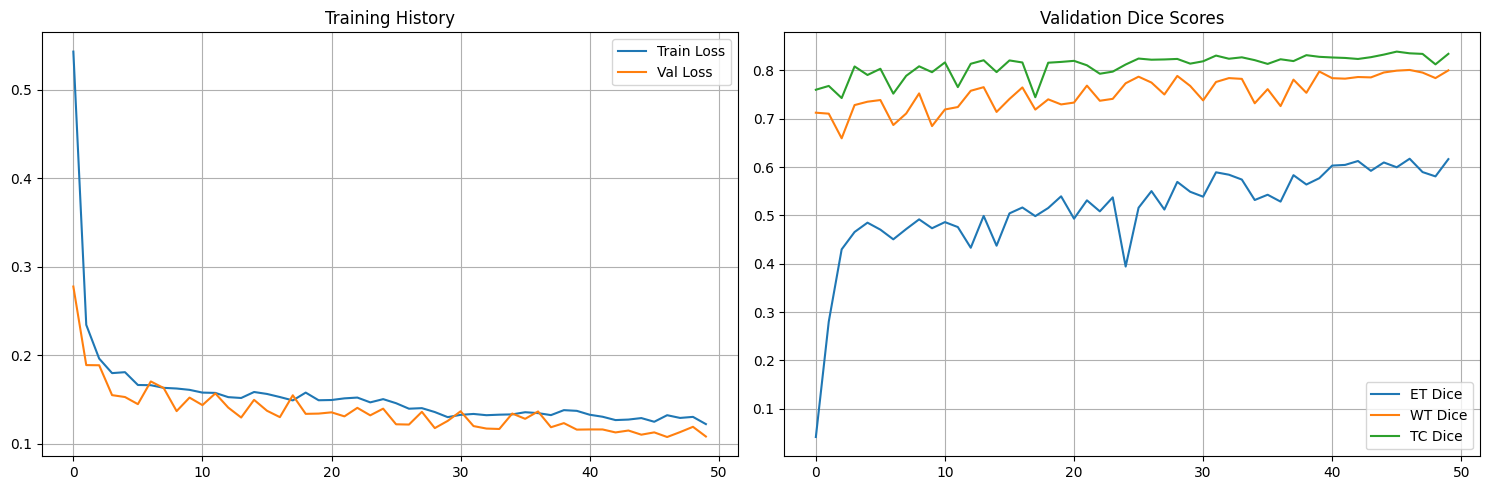

In [10]:
# Final results
if val_dice_scores:
    final_dice = val_dice_scores[-1]
    print(f"Final Results:")
    print(f"ET Dice: {final_dice[0]:.3f}")
    print(f"WT Dice: {final_dice[1]:.3f}")
    print(f"TC Dice: {final_dice[2]:.3f}")
    print(f"Average: {np.mean(final_dice):.3f}")
    
    # Final plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_title('Training History')
    ax1.legend()
    ax1.grid(True)
    
    dice_array = np.array(val_dice_scores)
    ax2.plot(dice_array[:, 0], label='ET Dice')
    ax2.plot(dice_array[:, 1], label='WT Dice')
    ax2.plot(dice_array[:, 2], label='TC Dice')
    ax2.set_title('Validation Dice Scores')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
    plt.show()

/tmp/ipykernel_37653/650388886.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab10_colors = cm.get_cmap('tab10')



BraTS20_Training_134:
  Dice Scores - ET: 0.854, WT: 0.719, TC: 0.851
  Ground Truth Classes: ['Background: 95.5%', 'Necrotic: 3.3%', 'Edema: 0.5%', 'Enhancing: 0.7%']
  Predicted Classes: ['Background: 96.1%', 'Necrotic: 2.6%', 'Edema: 0.5%', 'Enhancing: 0.7%']

BraTS20_Training_292:
  Dice Scores - ET: 0.894, WT: 0.654, TC: 0.660
  Ground Truth Classes: ['Background: 96.1%', 'Necrotic: 0.7%', 'Edema: 3.2%']
  Predicted Classes: ['Background: 98.6%', 'Necrotic: 0.1%', 'Edema: 1.3%']

BraTS20_Training_132:
  Dice Scores - ET: 0.187, WT: 0.883, TC: 0.880
  Ground Truth Classes: ['Background: 75.6%', 'Necrotic: 0.9%', 'Edema: 12.4%', 'Enhancing: 11.1%']
  Predicted Classes: ['Background: 76.8%', 'Necrotic: 0.3%', 'Edema: 10.6%', 'Enhancing: 12.3%']

BraTS20_Training_204:
  Dice Scores - ET: 0.562, WT: 0.595, TC: 0.940
  Ground Truth Classes: ['Background: 100.0%']
  Predicted Classes: ['Background: 100.0%']

BraTS20_Training_349:
  Dice Scores - ET: 0.948, WT: 0.873, TC: 0.836
  Ground 

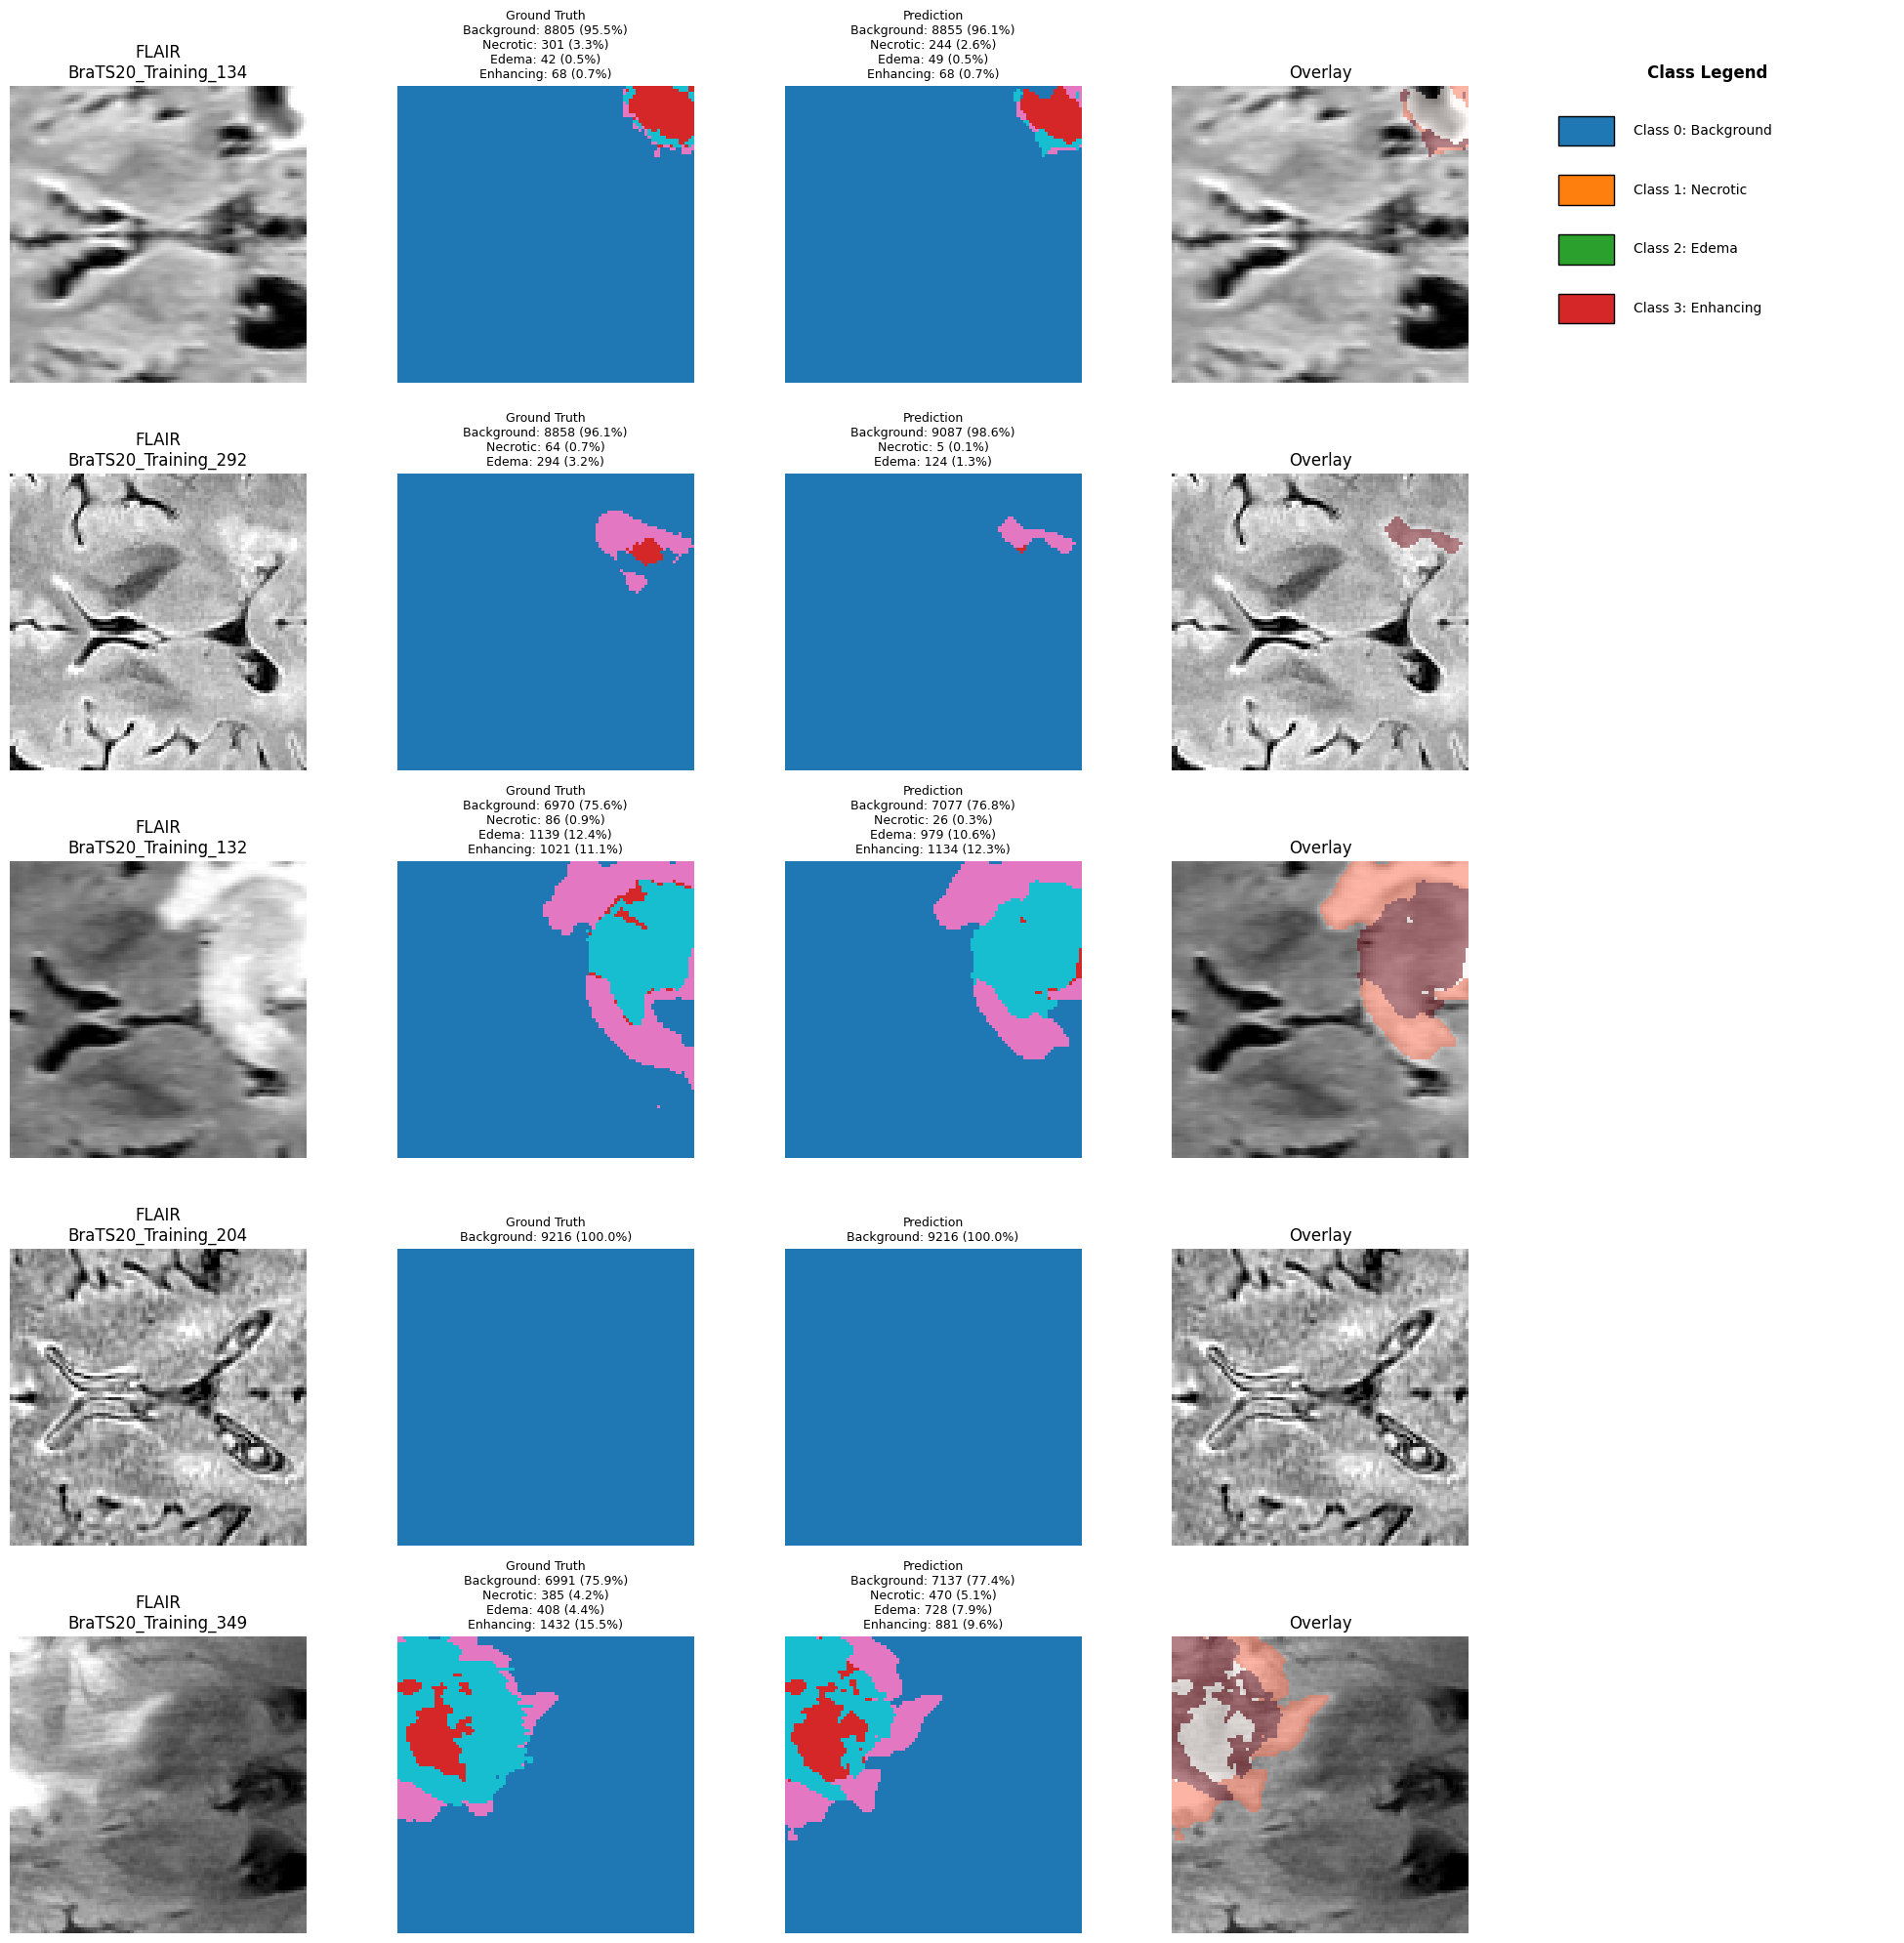

In [11]:
def visualize_predictions(model, val_loader, device, num_samples=5):
    model.eval()

    # Get samples from dataset directly (before normalization)
    dataset = val_loader.dataset.dataset  # Get original dataset
    indices = list(range(len(dataset)))
    import random
    random_indices = random.sample(indices, min(num_samples, len(indices)))

    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))  # Added column for legend
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    class_names = ['Background', 'Necrotic', 'Edema', 'Enhancing']
    # Get actual colors from tab10 colormap
    import matplotlib.cm as cm
    tab10_colors = cm.get_cmap('tab10')
    class_colors = [tab10_colors(i) for i in range(4)]

    with torch.no_grad():
        for idx, data_idx in enumerate(random_indices):
            # Get original data
            images, targets, patient_id = dataset[data_idx]

            # Get prediction
            images_batch = images.unsqueeze(0).to(device)
            targets_batch = targets.unsqueeze(0).to(device)

            with torch.amp.autocast('cuda'):
                outputs = model(images_batch)
            pred = torch.argmax(torch.softmax(outputs, dim=1), dim=1)

            # Get middle slice
            mid_slice = images.shape[3] // 2  # Depth dimension

            # Get raw FLAIR (before normalization)
            img_slice = images[0, :, :, mid_slice].cpu().numpy()  # FLAIR channel
            target_slice = targets[:, :, mid_slice].cpu().numpy()
            pred_slice = pred[0, :, :, mid_slice].cpu().numpy()

            # Clip extreme values and normalize
            img_slice = np.clip(img_slice, np.percentile(img_slice, 1), np.percentile(img_slice, 99))
            img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min() + 1e-8)

            # Calculate class statistics for the slice
            total_pixels = target_slice.size

            # Ground truth class counts
            gt_counts = {}
            pred_counts = {}

            for class_idx in range(4):
                gt_count = (target_slice == class_idx).sum()
                pred_count = (pred_slice == class_idx).sum()
                gt_counts[class_idx] = (gt_count, gt_count/total_pixels*100)
                pred_counts[class_idx] = (pred_count, pred_count/total_pixels*100)

            # Plot
            axes[idx, 0].imshow(img_slice, cmap='gray')
            axes[idx, 0].set_title(f'FLAIR\n{patient_id}')
            axes[idx, 0].axis('off')

            axes[idx, 1].imshow(target_slice, cmap='tab10', vmin=0, vmax=3)
            gt_text = "Ground Truth\n" + "\n".join([f"{class_names[i]}: {gt_counts[i][0]} ({gt_counts[i][1]:.1f}%)"
                                                   for i in range(4) if gt_counts[i][0] > 0])
            axes[idx, 1].set_title(gt_text, fontsize=9)
            axes[idx, 1].axis('off')

            axes[idx, 2].imshow(pred_slice, cmap='tab10', vmin=0, vmax=3)
            pred_text = "Prediction\n" + "\n".join([f"{class_names[i]}: {pred_counts[i][0]} ({pred_counts[i][1]:.1f}%)"
                                                    for i in range(4) if pred_counts[i][0] > 0])
            axes[idx, 2].set_title(pred_text, fontsize=9)
            axes[idx, 2].axis('off')

            # Overlay
            axes[idx, 3].imshow(img_slice, cmap='gray')
            mask = pred_slice > 0
            axes[idx, 3].imshow(np.ma.masked_where(~mask, pred_slice), cmap='Reds', alpha=0.5)
            axes[idx, 3].set_title('Overlay')
            axes[idx, 3].axis('off')

            # Legend (only for first row)
            if idx == 0:
                axes[idx, 4].axis('off')
                axes[idx, 4].set_title('Class Legend', fontsize=12, weight='bold')

                # Create legend patches
                for class_idx in range(4):
                    color = class_colors[class_idx]
                    # Create colored rectangle
                    rect = plt.Rectangle((0.1, 0.8 - class_idx * 0.2), 0.15, 0.1,
                                       facecolor=color, edgecolor='black')
                    axes[idx, 4].add_patch(rect)
                    # Add text
                    axes[idx, 4].text(0.3, 0.85 - class_idx * 0.2,
                                     f"Class {class_idx}: {class_names[class_idx]}",
                                     fontsize=10, va='center')

                axes[idx, 4].set_xlim(0, 1)
                axes[idx, 4].set_ylim(0, 1)
            else:
                # For other rows, hide the legend column
                axes[idx, 4].axis('off')

            # Print detailed stats (dice scores only in console)
            dice_scores = dice_coefficient(outputs, targets_batch)
            print(f"\n{patient_id}:")
            print(f"  Dice Scores - ET: {dice_scores[0]:.3f}, WT: {dice_scores[1]:.3f}, TC: {dice_scores[2]:.3f}")
            print(f"  Ground Truth Classes: {[f'{class_names[i]}: {gt_counts[i][1]:.1f}%' for i in range(4) if gt_counts[i][0] > 0]}")
            print(f"  Predicted Classes: {[f'{class_names[i]}: {pred_counts[i][1]:.1f}%' for i in range(4) if pred_counts[i][0] > 0]}")

    plt.tight_layout()
    plt.savefig('predictions_with_legend.png', dpi=300, bbox_inches='tight')
    plt.show()

# Run visualization
visualize_predictions(model, val_loader, device, num_samples=5)

## Understanding Model Architecture and Structure

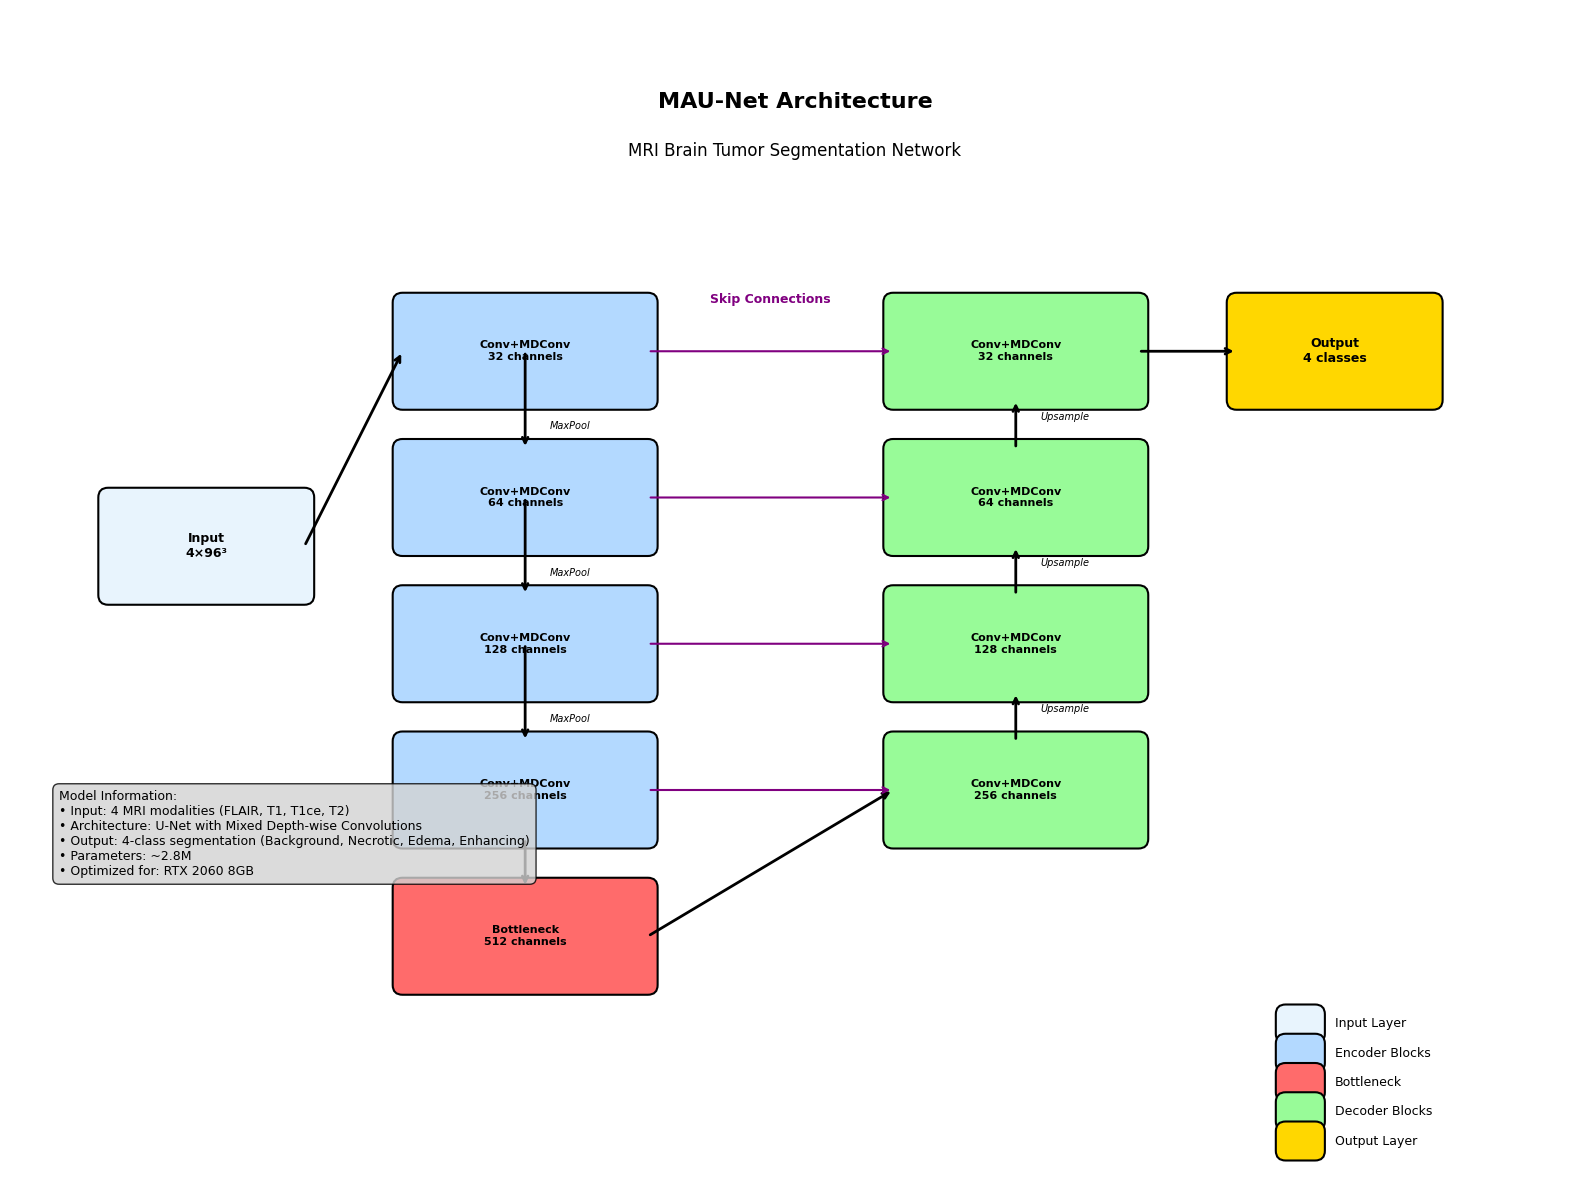

✅ Network architecture saved as 'mau_net_architecture.png'


In [12]:
def visualize_network_architecture():
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from matplotlib.patches import FancyBboxPatch, ConnectionPatch

    fig, ax = plt.subplots(1, 1, figsize=(16, 12))
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 12)
    ax.axis('off')

    # Define colors
    colors = {
        'input': '#E8F4FD',
        'encoder': '#B3D9FF',
        'bottleneck': '#FF6B6B',
        'decoder': '#98FB98',
        'output': '#FFD700',
        'skip': '#DDA0DD'
    }

    # Helper function to draw blocks
    def draw_block(x, y, width, height, text, color, fontsize=10):
        box = FancyBboxPatch((x, y), width, height,
                           boxstyle="round,pad=0.1",
                           facecolor=color,
                           edgecolor='black',
                           linewidth=1.5)
        ax.add_patch(box)
        ax.text(x + width/2, y + height/2, text,
               ha='center', va='center', fontsize=fontsize, weight='bold')

    # Helper function to draw arrows
    def draw_arrow(x1, y1, x2, y2, color='black', style='->', width=2):
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                   arrowprops=dict(arrowstyle=style, color=color, lw=width))

    # Input
    draw_block(1, 6, 2, 1, 'Input\n4×96³', colors['input'], 9)

    # Encoder path
    encoder_blocks = [
        ('Conv+MDConv\n32 channels', 4, 8),
        ('Conv+MDConv\n64 channels', 4, 6.5),
        ('Conv+MDConv\n128 channels', 4, 5),
        ('Conv+MDConv\n256 channels', 4, 3.5)
    ]

    for i, (text, x, y) in enumerate(encoder_blocks):
        draw_block(x, y, 2.5, 1, text, colors['encoder'], 8)
        if i == 0:
            draw_arrow(3, 6.5, 4, 8.5)  # Input to first encoder
        if i < len(encoder_blocks) - 1:
            draw_arrow(5.25, y + 0.5, 5.25, encoder_blocks[i+1][2] + 1)  # Down arrows
            ax.text(5.5, y - 0.3, 'MaxPool', fontsize=7, style='italic')

    # Bottleneck
    draw_block(4, 2, 2.5, 1, 'Bottleneck\n512 channels', colors['bottleneck'], 8)
    draw_arrow(5.25, 3.5, 5.25, 3)

    # Decoder path
    decoder_blocks = [
        ('Conv+MDConv\n256 channels', 9, 3.5),
        ('Conv+MDConv\n128 channels', 9, 5),
        ('Conv+MDConv\n64 channels', 9, 6.5),
        ('Conv+MDConv\n32 channels', 9, 8)
    ]

    for i, (text, x, y) in enumerate(decoder_blocks):
        draw_block(x, y, 2.5, 1, text, colors['decoder'], 8)
        if i == 0:
            draw_arrow(6.5, 2.5, 9, 4)  # Bottleneck to first decoder
        if i < len(decoder_blocks) - 1:
            draw_arrow(10.25, y + 1, 10.25, decoder_blocks[i+1][2])  # Up arrows
            ax.text(10.5, y + 1.3, 'Upsample', fontsize=7, style='italic')

    # Skip connections
    skip_connections = [
        (6.5, 8.5, 9, 8.5),    # enc1 to dec4
        (6.5, 7, 9, 7),        # enc2 to dec3
        (6.5, 5.5, 9, 5.5),    # enc3 to dec2
        (6.5, 4, 9, 4)         # enc4 to dec1
    ]

    for x1, y1, x2, y2 in skip_connections:
        draw_arrow(x1, y1, x2, y2, color='purple', width=1.5)

    # Add skip connection label
    ax.text(7.75, 9, 'Skip Connections', ha='center', fontsize=9,
           color='purple', weight='bold')

    # Output
    draw_block(12.5, 8, 2, 1, 'Output\n4 classes', colors['output'], 9)
    draw_arrow(11.5, 8.5, 12.5, 8.5)

    # Add title and labels
    ax.text(8, 11, 'MAU-Net Architecture', ha='center', fontsize=16, weight='bold')
    ax.text(8, 10.5, 'MRI Brain Tumor Segmentation Network', ha='center', fontsize=12)

    # Add legend
    legend_elements = [
        ('Input Layer', colors['input']),
        ('Encoder Blocks', colors['encoder']),
        ('Bottleneck', colors['bottleneck']),
        ('Decoder Blocks', colors['decoder']),
        ('Output Layer', colors['output'])
    ]

    for i, (label, color) in enumerate(legend_elements):
        y_pos = 1.5 - i * 0.3
        draw_block(13, y_pos, 0.3, 0.2, '', color)
        ax.text(13.5, y_pos + 0.1, label, fontsize=9, va='center')

    # Add model info
    info_text = f"""Model Information:
• Input: 4 MRI modalities (FLAIR, T1, T1ce, T2)
• Architecture: U-Net with Mixed Depth-wise Convolutions
• Output: 4-class segmentation (Background, Necrotic, Edema, Enhancing)
• Parameters: ~2.8M
• Optimized for: RTX 2060 8GB"""

    ax.text(0.5, 4, info_text, fontsize=9, va='top',
           bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.savefig('mau_net_architecture.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Network architecture saved as 'mau_net_architecture.png'")

# Generate the visualization
visualize_network_architecture()

In [13]:
def analyze_network_structure():
    model = SimpleMAUNet()

    print("=== MAU-Net Architecture Analysis ===\n")

    # Input Layer
    print("INPUT LAYER:")
    print(f"• Nodes: 4 × 96³ = {4 * 96**3:,} input features")
    print(f"• Represents: 4 MRI modalities (FLAIR, T1, T1ce, T2)")

    print("\nHIDDEN LAYERS:")

    # Count layers and parameters
    layer_count = 0
    total_params = 0

    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv3d, torch.nn.BatchNorm3d)):
            layer_count += 1
            params = sum(p.numel() for p in module.parameters())
            total_params += params

            if isinstance(module, torch.nn.Conv3d):
                in_ch, out_ch = module.in_channels, module.out_channels
                kernel = module.kernel_size
                print(f"• Layer {layer_count}: Conv3d({in_ch}→{out_ch}, kernel={kernel}) - {params:,} params")

    print(f"\nTOTAL HIDDEN LAYERS: {layer_count}")

    # Feature map sizes through network
    print(f"\nFEATURE MAP PROGRESSION:")
    x = torch.randn(1, 4, 96, 96, 96)

    # Track through encoder
    sizes = []
    e1 = model.enc1(x)
    sizes.append(f"Encoder 1: {e1.shape[1]} channels × {e1.shape[2]}³ = {e1.numel():,} features")

    e2 = model.enc2(torch.nn.functional.max_pool3d(e1, 2))
    sizes.append(f"Encoder 2: {e2.shape[1]} channels × {e2.shape[2]}³ = {e2.numel():,} features")

    e3 = model.enc3(torch.nn.functional.max_pool3d(e2, 2))
    sizes.append(f"Encoder 3: {e3.shape[1]} channels × {e3.shape[2]}³ = {e3.numel():,} features")

    e4 = model.enc4(torch.nn.functional.max_pool3d(e3, 2))
    sizes.append(f"Encoder 4: {e4.shape[1]} channels × {e4.shape[2]}³ = {e4.numel():,} features")

    b = model.bottleneck(torch.nn.functional.max_pool3d(e4, 2))
    sizes.append(f"Bottleneck: {b.shape[1]} channels × {b.shape[2]}³ = {b.numel():,} features")

    for size in sizes:
        print(f"• {size}")

    print(f"\nOUTPUT LAYER:")
    print(f"• Nodes: 4 × 96³ = {4 * 96**3:,} output features")
    print(f"• Represents: 4 classes (Background, Necrotic, Edema, Enhancing)")

    print(f"\nSUMMARY:")
    print(f"• Total Parameters: {total_params:,}")
    print(f"• Total Layers: {layer_count}")
    print(f"• Input Features: {4 * 96**3:,}")
    print(f"• Output Features: {4 * 96**3:,}")
    print(f"• Architecture: Encoder-Decoder with Skip Connections")

# Run analysis
analyze_network_structure()

=== MAU-Net Architecture Analysis ===

INPUT LAYER:
• Nodes: 4 × 96³ = 3,538,944 input features
• Represents: 4 MRI modalities (FLAIR, T1, T1ce, T2)

HIDDEN LAYERS:
• Layer 1: Conv3d(4→32, kernel=(3, 3, 3)) - 3,488 params
• Layer 3: Conv3d(32→64, kernel=(3, 3, 3)) - 55,360 params
• Layer 5: Conv3d(64→128, kernel=(3, 3, 3)) - 221,312 params
• Layer 7: Conv3d(128→256, kernel=(3, 3, 3)) - 884,992 params
• Layer 9: Conv3d(256→512, kernel=(3, 3, 3)) - 3,539,456 params
• Layer 11: Conv3d(768→256, kernel=(3, 3, 3)) - 5,308,672 params
• Layer 13: Conv3d(384→128, kernel=(3, 3, 3)) - 1,327,232 params
• Layer 15: Conv3d(192→64, kernel=(3, 3, 3)) - 331,840 params
• Layer 17: Conv3d(96→32, kernel=(3, 3, 3)) - 82,976 params
• Layer 19: Conv3d(32→4, kernel=(1, 1, 1)) - 132 params

TOTAL HIDDEN LAYERS: 19

FEATURE MAP PROGRESSION:
• Encoder 1: 32 channels × 96³ = 28,311,552 features
• Encoder 2: 64 channels × 48³ = 7,077,888 features
• Encoder 3: 128 channels × 24³ = 1,769,472 features
• Encoder 4: 25